In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
provider = pd.read_csv('healthcare_fraud_data/Train-1542865627584.csv')
bene = pd.read_csv('healthcare_fraud_data/Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('healthcare_fraud_data/Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('healthcare_fraud_data/Train_Outpatientdata-1542865627584.csv')

In [3]:
inpatient['patient_type'] = 'inpatient'
outpatient['patient_type'] = 'outpatient'

In [4]:
patients = pd.concat([inpatient,outpatient], axis = 0)

In [5]:
merged_data = patients.merge(bene, how = 'left', on = 'BeneID')

In [6]:
final_patients = merged_data.merge(provider, how = 'left', on = 'Provider')

In [7]:
#making a copy of merged data
patient_record = final_patients.copy()

## Changing into DateTime 

In [8]:
patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']] = \
    patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']].apply(pd.to_datetime, 
                                                                                               format ='%Y-%m-%d')

## Total number of patients and type of patient(inpatient, outpatient, both)

In [9]:
total = patient_record.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name = 'patient_count')
total = total.groupby('Provider')['patient_count'].count().reset_index()
provider2 = provider.merge(total, how = 'left', on = 'Provider')

In [10]:
inpatient_list = patient_record[patient_record['patient_type'] == 'inpatient'].Provider.to_list()
outpatient_list = patient_record[patient_record['patient_type'] == 'outpatient'].Provider.to_list()

In [11]:
common_patient = set(inpatient_list) & set(outpatient_list)

In [12]:
patient_record.loc[patient_record.Provider.isin(common_patient), 'common_patient'] = 'Both'
patient_record.loc[~patient_record.Provider.isin(common_patient), 'common_patient'] = 0

In [13]:
patient_record['patient_type'].mask(patient_record['common_patient'] == 'Both', 'both', inplace = True)

In [14]:
patient_type = patient_record[['Provider', 'patient_type']]

In [15]:
provider2 = provider2.merge(patient_type, how = 'left', on = 'Provider')

In [16]:
provider2.drop_duplicates(subset = ['Provider'],keep = 'first', inplace = True)

## Race

In [18]:
race = patient_record.groupby(['Provider', 'BeneID', 'Race'])['Race'].count().reset_index(name = 'race_count')

In [20]:
race2 = race.groupby(['Provider', 'Race'])['race_count'].count().reset_index(name = 'race_count1')

In [21]:
race2 = race2.pivot(index = 'Provider', columns = 'Race', values = 'race_count1')

In [22]:
race2.columns = ['Race1', 'Race2', 'Race3', 'Race5']

In [23]:
provider2 = provider2.merge(race2, how = 'left', on = 'Provider')

In [24]:
provider2[['Race1', 'Race2', 'Race3', 'Race5']] = provider2[['Race1', 'Race2', 'Race3', 'Race5']].fillna(0)

## Gender

In [25]:
gender = patient_record.groupby(['Provider', 'BeneID','Gender'])['Gender'].count().reset_index(name = 'gender_count')


In [26]:
gender2 = gender.groupby(['Provider', 'Gender'])['gender_count'].count().reset_index(name = 'gender_count1')

In [27]:
gender2 = gender2.pivot(index = 'Provider', columns = 'Gender', values = 'gender_count1')

In [28]:
gender2.columns = ['Male', 'Female']

In [30]:
provider2 = provider2.merge(gender2, how = 'left', on = 'Provider')

In [31]:
provider2[['Male', 'Female']] = provider2[['Male', 'Female']].fillna(0)

## Age

In [32]:
patient_record['Age'] = patient_record['ClaimStartDt'].dt.year.astype(int) - patient_record['DOB'].dt.year.astype(int)

In [33]:
age = patient_record.groupby(['Provider'])['Age'].mean().reset_index(name = 'mean_age').round()

In [35]:
provider2 = provider2.merge(age, how = 'left', on = 'Provider')

## State

In [37]:
state = patient_record.groupby(['Provider', 'State'])['State'].count().reset_index(name = 'state_count')
state = state.groupby('Provider')['state_count'].count().reset_index()

In [38]:
provider2 = provider2.merge(state, how = 'left', on = 'Provider')

## Physician

In [40]:
Att_phy = patient_record.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count()\
.reset_index(name = 'phy_count')

In [41]:
Att_phy = Att_phy.groupby('Provider')['phy_count'].count().reset_index()

In [42]:
provider2 = provider2.merge(Att_phy, how = 'left', on = 'Provider')

In [44]:
patient_record['noPhysician'] = patient_record[['AttendingPhysician','OperatingPhysician', 'OtherPhysician']]\
                                .isna().all(axis =1)


In [45]:
no_phy = patient_record.groupby(['Provider'])['noPhysician'].sum().reset_index(name = 'no_phy')

In [46]:
provider2 = provider2.merge(no_phy, how = 'left', on = 'Provider')

## Chronic condition

In [47]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [48]:
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]] = \
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]].fillna(0)

In [49]:
#Change the chronic condition to 1 or 0 encoding from 1, 2

patient_record = patient_record.replace({'ChronicCond_Alzheimer' :2, 'ChronicCond_Heartfailure' : 2, 
                                         'ChronicCond_KidneyDisease' :2,'ChronicCond_Cancer' :2, 
                                         'ChronicCond_ObstrPulmonary' :2 ,'ChronicCond_Depression' :2,
                                        'ChronicCond_Diabetes' :2, 'ChronicCond_IschemicHeart' :2,
                                         'ChronicCond_Osteoporasis' :2, 'ChronicCond_rheumatoidarthritis' :2,
                                        'ChronicCond_stroke' :2}, 0)


In [51]:
#change the renal disease indicator in binary encoding(0,1)
patient_record = patient_record.replace({'RenalDiseaseIndicator' :'Y'},1 )
patient_record['RenalDiseaseIndicator'] =patient_record['RenalDiseaseIndicator'].astype(int)

In [52]:
chronic = patient_record.columns[patient_record.columns.str.contains("Chronic")].tolist() 

In [53]:
chronic_data = pd.concat([patient_record[chronic], patient_record['RenalDiseaseIndicator']], axis = 1)

In [54]:
chronic_condition = chronic_data.columns.to_list()

In [55]:
patient_record['chronic_count'] = patient_record[chronic_condition].sum(axis = 1)

In [56]:
chronic_mean = patient_record.groupby(['Provider'])['chronic_count'].mean().round().reset_index(name = 'chronic_mean')

In [57]:
provider2 = provider2.merge(chronic_mean, how = 'left', on = 'Provider')

## Claims 2 features(total claim, monthly distribution of claims)

In [59]:
claim = patient_record.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'claim_count')

In [60]:
provider2 = provider2.merge(claim, how = 'left', on = 'Provider')

In [61]:
patient_record['ClaimStartMonth'] = patient_record['ClaimStartDt'].dt.month.astype(int)

In [62]:
month_claim = patient_record.groupby(['Provider', 'ClaimStartMonth'])['ClaimID'].count().\
        reset_index(name = 'claim_month')

In [64]:
month_claim2 = month_claim.pivot(index = 'Provider', columns = 'ClaimStartMonth', values = 'claim_month')

In [65]:
month_claim2.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [66]:
provider2 = provider2.merge(month_claim2, how = 'left', on = 'Provider')

In [67]:
provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']] = \
    provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].fillna(0)

## Days Admitted

In [70]:
patient_record['days_admitted'] = (patient_record['ClaimEndDt'] - patient_record['ClaimStartDt']).dt.days.astype(int) 

In [71]:
patient_record['days_admitted'] = patient_record['days_admitted'] + 1

In [72]:
days_admitted = patient_record.groupby('Provider')['days_admitted'].mean().round().reset_index(name = 'days_admitted')

In [73]:
# provider2 = provider2.drop(['days_admitted'], inplace = True, axis = 1)

In [74]:
provider2 = provider2.merge(days_admitted, how = 'left', on = 'Provider')

## Financial Features

### InscClaimAmtReimbursed

<AxesSubplot:xlabel='PotentialFraud'>

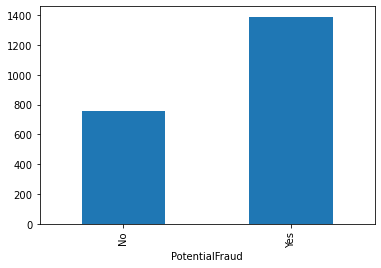

In [76]:
patient_record.groupby('PotentialFraud')['InscClaimAmtReimbursed'].mean().plot.bar()

In [77]:
Reim = patient_record.groupby('Provider')['InscClaimAmtReimbursed'].mean().reset_index(name = 'InscClaimAmtReimbursed')

In [78]:
provider2 = provider2.merge(Reim, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

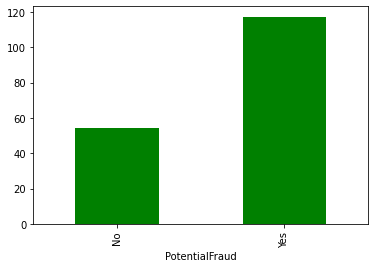

In [79]:
patient_record.groupby('PotentialFraud')['DeductibleAmtPaid'].mean().plot.bar(color = 'green')

In [80]:
deduct = patient_record.groupby('Provider')['DeductibleAmtPaid'].mean().reset_index(name = 'DeductibleAmtPaid')

In [81]:
provider2 = provider2.merge(deduct, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

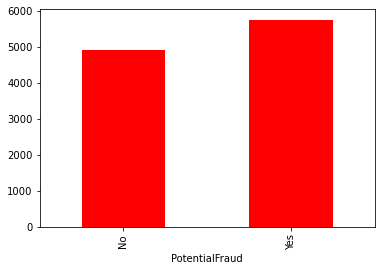

In [82]:
patient_record.groupby('PotentialFraud')['IPAnnualReimbursementAmt'].mean().plot.bar(color = 'red')

In [83]:
IP_reim = patient_record.groupby('Provider')['IPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'IPAnnualReimbursementAmt')

In [84]:
provider2 = provider2.merge(IP_reim, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

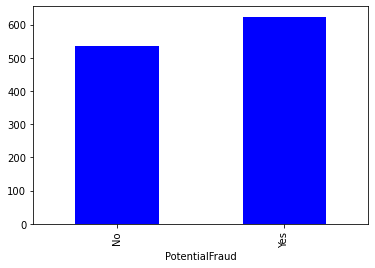

In [85]:
patient_record.groupby('PotentialFraud')['IPAnnualDeductibleAmt'].mean().plot.bar(color = 'blue')

In [86]:
IP_deduct = patient_record.groupby('Provider')['IPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'IPAnnualDeductibleAmt')

In [87]:
provider2 = provider2.merge(IP_deduct, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

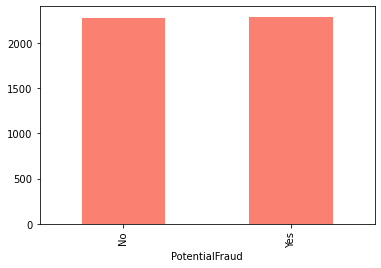

In [88]:
patient_record.groupby('PotentialFraud')['OPAnnualReimbursementAmt'].mean().plot.bar(color = 'salmon')

In [89]:
OP_reim = patient_record.groupby('Provider')['OPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'OPAnnualReimbursementAmt')

In [90]:
provider2 = provider2.merge(OP_reim, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

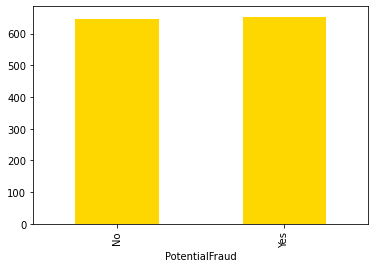

In [91]:
patient_record.groupby('PotentialFraud')['OPAnnualDeductibleAmt'].mean().plot.bar(color = 'gold')

In [92]:
OP_deduct = patient_record.groupby('Provider')['OPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'OPAnnualDeductibleAmt')

In [93]:
provider2 = provider2.merge(OP_deduct, how = 'left', on = 'Provider')

In [94]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,2.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,2.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,3.0,380.000000,4.642857,3962.142857,457.714286,3241.785714,886.785714
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,1.0,216.818182,0.000000,2785.454545,436.909091,1492.727273,805.454545
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,2.0,225.243902,4.512195,7026.585366,586.097561,2928.414634,707.317073
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000


In [95]:
patient_record['coverage'] = patient_record['InscClaimAmtReimbursed']\
                    /(patient_record['InscClaimAmtReimbursed'] + patient_record['DeductibleAmtPaid'])

In [96]:
coverage = patient_record.groupby('Provider')['coverage'].mean().reset_index(name = 'coverage')

In [97]:
provider2 = provider2.merge(coverage, how = 'left', on = 'Provider')

<AxesSubplot:xlabel='PotentialFraud'>

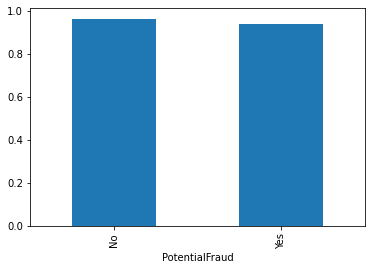

In [98]:
provider2.groupby('PotentialFraud')['coverage'].mean().plot.bar()

In [99]:
#Locate columns with NA values in coverage
provider2.loc[np.isnan(provider2['coverage'])]
#Impute with column mode
provider2['coverage'].fillna(provider2['coverage'].mode()[0], inplace=True)

### Total Amount charged

In [100]:
patient_record['totalamount_charged'] = patient_record['InscClaimAmtReimbursed'] +patient_record['DeductibleAmtPaid']

In [101]:
total = patient_record.groupby('Provider')['totalamount_charged'].mean().reset_index(name = 'totalamount_charged')

In [102]:
provider2 = provider2.merge(total, how = 'left', on = 'Provider')

### Revenue(daily_charge)

In [103]:
patient_record['revenue_per_day'] = patient_record['totalamount_charged']/ patient_record['days_admitted']

In [104]:
revenue = patient_record.groupby('Provider')['revenue_per_day'].mean().reset_index(name = 'revenue_day')

In [105]:
provider2 = provider2.merge(revenue, how = 'left', on = 'Provider')

### Annual total amount

In [106]:
patient_record['annual_amount'] = patient_record['IPAnnualReimbursementAmt'] + patient_record['IPAnnualDeductibleAmt']\
                + patient_record['OPAnnualReimbursementAmt'] + patient_record['OPAnnualDeductibleAmt']

In [107]:
annual_amount = patient_record.groupby('Provider')['annual_amount'].mean().reset_index(name = 'annual_amount')

In [108]:
provider2 = provider2.merge(annual_amount, how = 'left', on = 'Provider')

## Diagnosis and procedural codes

In [110]:
claimdiag = patient_record.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClmAdmitDiagnosisCode'].count()\
            .reset_index(name = 'claimdiag')
claimdiag2 = claimdiag.groupby('Provider')['claimdiag'].count().reset_index()

In [111]:
provider2 = provider2.merge(claimdiag2, how = 'left', on = 'Provider')

In [112]:
diag_grp = patient_record.groupby(['Provider', 'DiagnosisGroupCode'])['DiagnosisGroupCode'].count()\
            .reset_index(name = 'diag_grp')
diag_grp2 = diag_grp.groupby('Provider')['diag_grp'].count().reset_index()

In [113]:
provider2 = provider2.merge(diag_grp2, how = 'left', on = 'Provider')

In [114]:
provider2[['claimdiag', 'diag_grp']] =provider2[['claimdiag', 'diag_grp']].fillna(0)

In [115]:
diagnosis = pd.DataFrame(columns = ['diag_code'])
diagnosis['diag_code'] = pd.concat([patient_record["ClmDiagnosisCode_1"],  patient_record["ClmDiagnosisCode_2"], 
                patient_record["ClmDiagnosisCode_3"], patient_record["ClmDiagnosisCode_4"],
                patient_record["ClmDiagnosisCode_5"], patient_record["ClmDiagnosisCode_6"],
                patient_record["ClmDiagnosisCode_7"],patient_record["ClmDiagnosisCode_8"],
                patient_record["ClmDiagnosisCode_9"],patient_record["ClmDiagnosisCode_10"]], axis=0)

In [116]:
#Most freq used diag codes
diagnosis.diag_code.value_counts().head(11).reset_index()

,index,diag_code
0,0,3901394
1,4019,77056
2,25000,37356
3,2724,35763
4,V5869,24904
5,4011,23773
6,42731,20138
7,V5861,20001
8,2720,18268
9,2449,17600


In [117]:
repeat_prov =pd.DataFrame(columns = ['Provider'])
repeat_prov = pd.DataFrame(pd.concat([patient_record['Provider']]*10))

In [118]:
merged_diag = pd.concat([repeat_prov, diagnosis], axis = 1)

In [119]:
DiagCode = merged_diag.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [120]:
diag_codelst = ['4019', '25000', '2724', 'V5869', '4011', '42731', 'V5861', '2720', '2449', '4280']
merged_diag2 = merged_diag[merged_diag['diag_code'].isin(diag_codelst)]

In [121]:
DiagCode = merged_diag2.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [122]:
diagnosis_code = DiagCode.pivot(index = 'Provider', columns = 'diag_code', values = 'diag_count')

In [123]:
diagnosis_code.columns = ['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']

In [124]:
provider2 = provider2.merge(diagnosis_code, how = 'left', on = 'Provider')

In [125]:
provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']] = \
            provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                             'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']].fillna(0)

### Procedure codes

In [127]:
procedure = pd.DataFrame(columns = ['proc_code'])
procedure['proc_code'] = pd.concat([patient_record["ClmProcedureCode_1"],  patient_record["ClmProcedureCode_2"], 
                patient_record["ClmProcedureCode_3"], patient_record["ClmProcedureCode_4"],
                patient_record["ClmProcedureCode_5"], patient_record['ClmProcedureCode_6']], axis=0)

In [128]:
procedure.proc_code.value_counts().head(11).reset_index()

,index,proc_code
0,0.0,2761159
1,4019.0,1959
2,9904.0,1152
3,2724.0,1054
4,8154.0,1022
5,66.0,901
6,3893.0,854
7,3995.0,809
8,4516.0,651
9,3722.0,589


In [129]:
repeat_prov2 =pd.DataFrame(columns = ['Provider'])
repeat_prov2 = pd.DataFrame(pd.concat([patient_record['Provider']]*6))

In [130]:
merged_proc = pd.concat([repeat_prov2, procedure], axis = 1)

In [131]:
ProcCode = merged_proc.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [132]:
proc_codelist = ['4019', '9904', '2724', '8154', '66', '3893', '3995', '4516', '3722', '8151']
merged_proc2 = merged_proc[merged_proc['proc_code'].isin(proc_codelist)]

In [133]:
ProcCode = merged_proc2.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [134]:
procedure_code = ProcCode.pivot(index = 'Provider', columns = 'proc_code', values = 'proc_count')

In [135]:
procedure_code.columns = ['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']

In [136]:
provider2 = provider2.merge(procedure_code, how = 'left', on = 'Provider')

In [137]:
provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']] = \
            provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']].fillna(0)

## Duplicates

In [138]:
#Duplicated_claims
duplicate_claim = patient_record[patient_record.duplicated(subset = [
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [139]:
duplicated_claims = duplicate_claim.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'duplicate_claims')

In [140]:
provider2 = provider2.merge(duplicated_claims, how = 'left', on = 'Provider')

In [141]:
provider2[['duplicate_claims']] = provider2[['duplicate_claims']].fillna(0)

In [142]:
#Duplicated_bene_count
patient_duplicates = patient_record[patient_record.duplicated(subset = ['BeneID','Provider',
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [144]:
patient_duplicate_count = patient_duplicates.groupby(['Provider', 'BeneID'])['BeneID'].count().\
                            reset_index(name = 'patient_duplicate_count')

In [145]:
patient_duplicate_count = patient_duplicate_count.groupby('Provider')['patient_duplicate_count'].count().reset_index()

In [146]:
provider2 = provider2.merge(patient_duplicate_count, how = 'left', on = 'Provider')

In [147]:
provider2[['patient_duplicate_count']] = provider2[['patient_duplicate_count']].fillna(0)

In [148]:
provider2.sample(10)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage,totalamount_charged,revenue_day,annual_amount,claimdiag,diag_grp,diag_4019,diag_25000,diag_2724,diag_V5869,diag_4011,diag_42731,diag_V5861,diag_2720,diag_2449,diag_4280,proc_4019,proc_9904,proc_2724,proc_8154,proc_66,proc_3893,proc_3995,proc_4516,proc_3722,proc_8151,duplicate_claims,patient_duplicate_count
4369,PRV56467,No,188,outpatient,164.0,24.0,0.0,0.0,75.0,113.0,71.0,3,28,1,4.0,349,31.0,21.0,29.0,28.0,42.0,34.0,24.0,32.0,31.0,25.0,30.0,22.0,3.0,274.269341,2.636103,1939.799427,244.618911,2455.959885,772.349570,0.982831,276.905444,225.538445,5412.727794,60.0,0.0,8.0,18.0,6.0,20.0,17.0,51.0,15.0,10.0,17.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,1.0
2156,PRV53683,No,8,both,6.0,1.0,0.0,1.0,1.0,7.0,74.0,3,8,0,4.0,9,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,3.0,4144.444444,237.333333,8966.666667,712.000000,1504.444444,194.444444,0.985433,4381.777778,1100.083333,11377.555556,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
571,PRV51716,No,64,outpatient,48.0,4.0,8.0,4.0,24.0,40.0,74.0,1,3,0,5.0,82,2.0,7.0,7.0,6.0,10.0,6.0,9.0,10.0,7.0,4.0,7.0,7.0,2.0,280.853659,1.341463,3787.073171,377.707317,1850.365854,562.682927,0.988138,282.195122,243.151374,6577.829268,12.0,0.0,1.0,10.0,1.0,1.0,2.0,11.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0
4931,PRV57183,No,45,outpatient,36.0,8.0,1.0,0.0,21.0,24.0,75.0,3,24,0,4.0,52,4.0,5.0,1.0,3.0,4.0,4.0,7.0,1.0,4.0,6.0,10.0,3.0,3.0,253.269231,3.846154,3145.769231,472.384615,2485.769231,683.846154,0.979378,257.115385,215.680861,6787.769231,8.0,0.0,2.0,2.0,1.0,1.0,2.0,5.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
5121,PRV57409,Yes,64,both,58.0,5.0,0.0,1.0,26.0,38.0,71.0,3,40,0,4.0,71,6.0,8.0,5.0,2.0,8.0,6.0,12.0,5.0,5.0,5.0,5.0,4.0,4.0,3079.154930,361.014085,8846.056338,872.450704,3074.507042,730.478873,0.937624,3440.169014,752.238725,13523.492958,36.0,21.0,7.0,4.0,2.0,6.0,0.0,11.0,6.0,5.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,29.0,1.0
87,PRV51115,No,6,outpatient,3.0,3.0,0.0,0.0,1.0,5.0,73.0,1,3,0,4.0,7,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,140.000000,2.857143,4142.857143,762.857143,1530.000000,474.285714,0.976190,142.857143,142.857143,6910.000000,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1582,PRV52961,No,5,outpatient,4.0,1.0,0.0,0.0,2.0,3.0,64.0,1,2,0,5.0,5,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,64.000000,0.000000,600.000000,213.600000,676.000000,372.000000,1.000000,64.000000,64.000000,1861.600000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
895,PRV52121,No,50,both,43.0,7.0,0.0,0.0,25.0,25.0,73.0,9,20,0,4.0,53,6.0,3.0,5.0,5.0,7.0,3.0,3.0,8.0,3.0,5.0,2.0,3.0,3.0,936.037736,87.584906,4024.905660,483.622642,1918.113208,624.528302,0.964661,1023.622642,403.433064,7051.169811,10.0,4.0,4.0,4.0,1.0,3.0,1.0,7.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0
3850,PRV55814,No,4,outpatient,4.0,0.0,0.0,0.0,2.0,2.0,62.0,1,1,0,3.0,4,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,27.500000,20.000000,3535.000000,267.000000,1152.500000,167.500000,0.777778,47.500000,47.500000,5122.000000,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3466,PRV55351,No,8,outpatient,7.0,0.0,1.0,0.0,1.0,7.0,80.0,1,1,0,6.0,10,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,165.000000,0.000000,2500.000000,427.200000,1543.000000,632.000000,1.000000,165.000000,159.000000,5102.200000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0

In [149]:
#Dummify patient type
provider2['Inpatient'] = [1 if x == 'inpatient' or x=='both' else 0 for x in provider2['patient_type']]
provider2['Outpatient'] = [1 if x == 'outpatient' or x=='both' else 0 for x in provider2['patient_type']]
#Encode PotentialFraud to 0 and 1
provider2['PotentialFraud'] = [1 if x == 'Yes' else 0 for x in provider2['PotentialFraud']]
provider2.sample(10)
provider2 = provider2.drop(['patient_type'], axis=1)

## Modelling Starts Here


In [286]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

#Imbalanced learn packages
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

In [187]:
#Confusion Matrix Plotting Function
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.4%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap='coolwarm');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Potential Fraud'])
    return

In [287]:
#Split dataset into X, y
x = provider2.drop(['Provider','PotentialFraud'],axis=1)
y = provider2['PotentialFraud']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x), y, test_size=0.3, random_state=100)

#RandomOverSampler split
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)

#SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

#Undersampling via Edited Nearest Neighbors
en = EditedNearestNeighbours()
x_en, y_en = en.fit_resample(x, y)

#Undersampling via Random Under Sampler
under = RandomUnderSampler()
x_un, y_un = under.fit_resample(x, y)

Accuracy Score: 0.9322242760320394
F1 Score: 0.5634920634920635


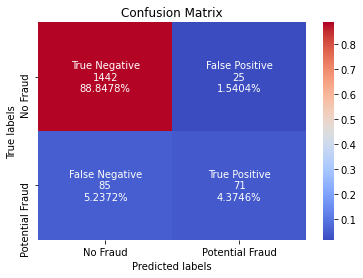

In [241]:
#Logistic Regression
lg1 = LogisticRegression(random_state=100, class_weight=None, max_iter=2000)

lg1.fit(X_train,y_train)

y_pred = lg1.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

In [153]:
print("Default model correctly classified %f percent of fraud cases in the test data" %((71/85)*100))
print("Default model misclassified %f percent of non-fraud cases in the test data" %((25/1442)*100))

Default model correctly classified 83.529412 percent of fraud cases in the test data
Default model misclassified 1.733703 percent of non-fraud cases in the test data


/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


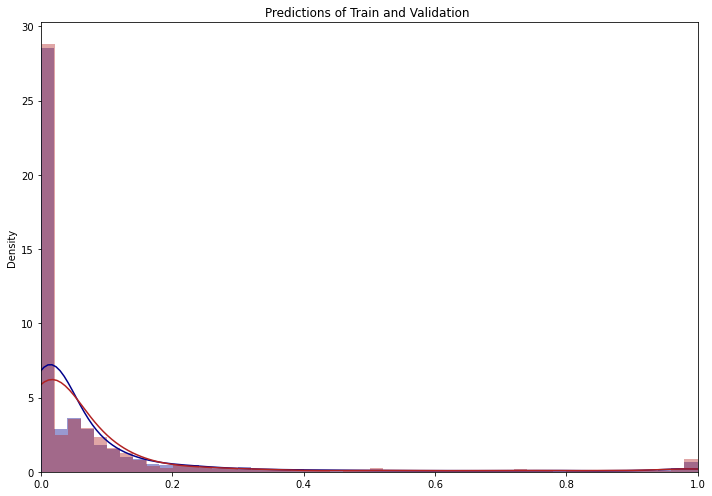

In [212]:
# Compare model prediction performance on train and validation

fig = plt.figure(figsize=(10,7))
sns.distplot(lg1.predict_proba(X_train)[:,1],color='darkblue')
sns.distplot(lg1.predict_proba(X_test)[:,1],color='firebrick')
plt.title('Predictions of Train and Validation ')
plt.xlim([0, 1])

plt.tight_layout()

plt.show()

In [254]:
# Feature Importance for original log regression
#top 15 features
pd.DataFrame(zip(x.columns, np.transpose(lg1.coef_.tolist()[0])), columns=['feature', 'coef']).sort_values('coef', ascending=False).head(15)

,feature,coef
60,Inpatient,0.895220
36,claimdiag,0.857500
44,diag_V5861,0.742044
37,diag_grp,0.688021
21,Sep,0.643809
14,Feb,0.436579
23,Nov,0.405382
20,Aug,0.311033
16,Apr,0.309784
30,OPAnnualReimbursementAmt,0.294231


In [253]:
#bottom 15 features for log regression
pd.DataFrame(zip(x.columns, np.transpose(lg1.coef_.tolist()[0])), columns=['feature', 'coef']).sort_values('coef', ascending=False).tail(15)

,feature,coef
10,no_phy,-0.134301
54,proc_3995,-0.145798
53,proc_3893,-0.148764
40,diag_2724,-0.182466
18,Jun,-0.183246
43,diag_42731,-0.208915
42,diag_4011,-0.217299
13,Jan,-0.219779
2,Race2,-0.237064
47,diag_4280,-0.249147


Accuracy Score: 0.8940234134319162
F1 Score: 0.5612244897959183


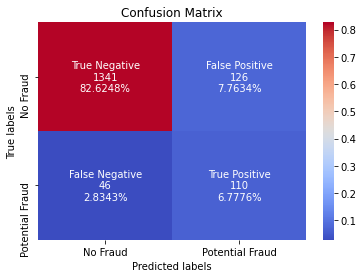

In [210]:
#Try Logistic Regression CV with balanced class weight
from sklearn.linear_model import LogisticRegressionCV

lg2 = LogisticRegressionCV(cv=10, random_state=100, class_weight='balanced', max_iter=2000)

lg2.fit(X_train,y_train)

y_pred = lg2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


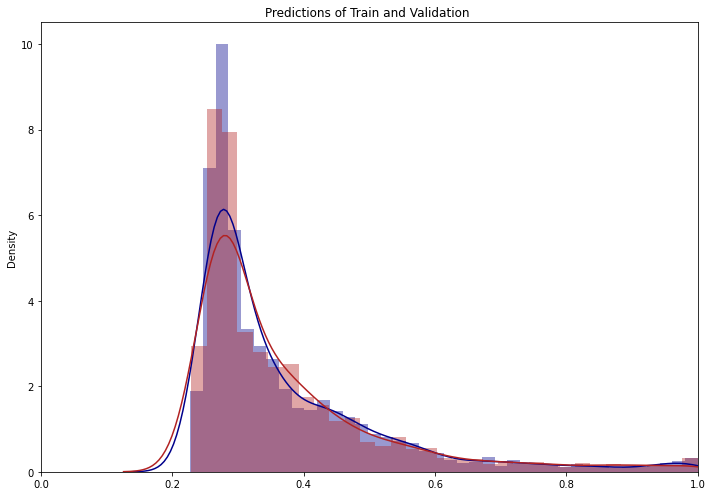

In [213]:
# Compare model prediction performance on train and validation

fig = plt.figure(figsize=(10,7))
sns.distplot(lg2.predict_proba(X_train)[:,1],color='darkblue')
sns.distplot(lg2.predict_proba(X_test)[:,1],color='firebrick')
plt.title('Predictions of Train and Validation ')
plt.xlim([0, 1])

plt.tight_layout()

plt.show()

/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Log Regression w/ ROS Accuracy Score: 0.872579001019368
F1 Score: 0.5634920634920635
ROS Confusion Matrix: 
[[1284  174]
 [ 201 1284]]


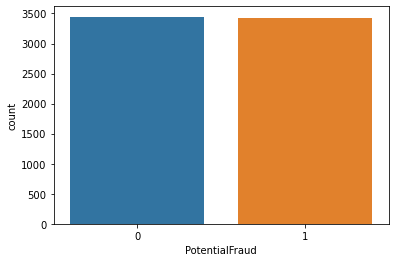

In [260]:
#RandomOverSampler train-test split
X_train_ROS, X_test_ROS, y_train_ROS, y_test_ROS = train_test_split(StandardScaler().fit_transform(x_over), y_over, test_size=0.3, random_state=100)
sns.countplot(y_train_ROS)

#Fit the logistic regression model using Random Over Sampler
lg1.fit(X_train_ROS,y_train_ROS)
y_pred_ROS = lg1.predict(X_test_ROS)
print(f'Log Regression w/ ROS Accuracy Score: {accuracy_score(y_test_ROS,y_pred_ROS)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print(f'ROS Confusion Matrix: \n{confusion_matrix(y_test_ROS, y_pred_ROS)}')


/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Log Regression w/ SMOTE Accuracy Score: 0.8858307849133538
F1 Score: 0.5634920634920635
Confusion Matrix: 
[[1314  144]
 [ 192 1293]]


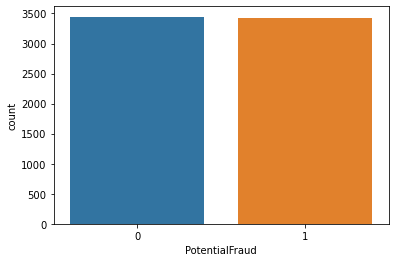

In [261]:
#SMOTE
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(StandardScaler().fit_transform(x_smote), y_smote, test_size=0.3, random_state=100)
sns.countplot(y_train_sm)
#Fit model
lg1.fit(X_train_sm,y_train_sm)
y_pred_sm = lg1.predict(X_test_sm)
print(f'Log Regression w/ SMOTE Accuracy Score: {accuracy_score(y_test_sm,y_pred_sm)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print(f'Confusion Matrix: \n{confusion_matrix(y_test_sm, y_pred_sm)}')

Log Regression w/ EN Undersampling Accuracy Score: 0.9455060155697098
F1 Score: 0.6980392156862745
Confusion Matrix: 
[[1247   15]
 [  62   89]]


/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


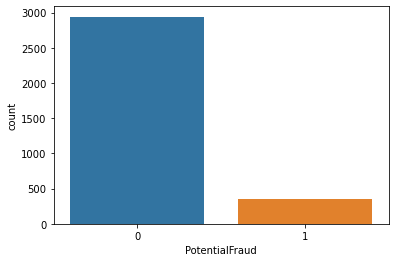

In [291]:
#EN Undersampling
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(StandardScaler().fit_transform(x_en), y_en, test_size=0.3, random_state=100)
sns.countplot(y_train_en) #shows that no samples were eliminated in this dataset
#Fit model
lg1.fit(X_train_en,y_train_en)
y_pred_en = lg1.predict(X_test_en)
print(f'Log Regression w/ EN Undersampling Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print(f'Confusion Matrix: \n{confusion_matrix(y_test_en, y_pred_en)}')

Log Regression w/ Random Undersampling Accuracy Score: 0.8618421052631579
F1 Score: 0.8478260869565217
Confusion Matrix: 
[[145  19]
 [ 23 117]]


/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


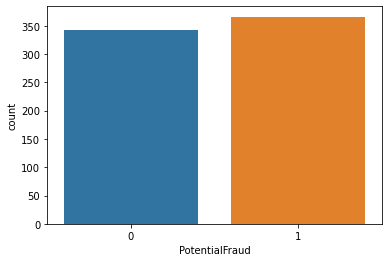

In [290]:
#Random Undersampling
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(StandardScaler().fit_transform(x_un), y_un, test_size=0.3, random_state=100)
sns.countplot(y_train_un)
#Fit model
lg1.fit(X_train_un,y_train_un)
y_pred_un = lg1.predict(X_test_un)
print(f'Log Regression w/ Random Undersampling Accuracy Score: {accuracy_score(y_test_un,y_pred_un)}')
print('F1 Score: {}'.format(f1_score(y_test_un, y_pred_un)))
print(f'Confusion Matrix: \n{confusion_matrix(y_test_un, y_pred_un)}')

Ridge Classifier Accuracy Score: 0.9297597042513863
F1 Score: 0.4910714285714286


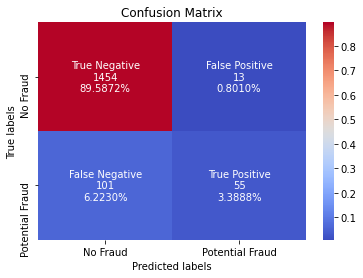

In [288]:
#Ridge Classifier
ridge = RidgeClassifier(random_state = 100)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(f'Ridge Classifier Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

Ridge Classifier w/ Balanced Class Weight Accuracy Score: 0.8398028342575478
F1 Score: 0.5131086142322099


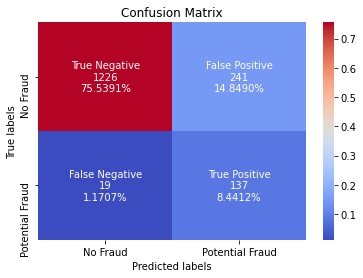

In [239]:
#Ridge Classifier with balanced class weight
ridge2 = RidgeClassifier(random_state = 100, class_weight='balanced')
ridge2.fit(X_train, y_train)
y_pred = ridge2.predict(X_test)
print(f'Ridge Classifier w/ Balanced Class Weight Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)
#Accuracy score decreased, but F1 score increased with balanced class weight adjustment

Accuracy Score: 0.9353049907578558
F1 Score: 0.5291479820627801
Confusion Matrix: 
[[1459    8]
 [  97   59]]


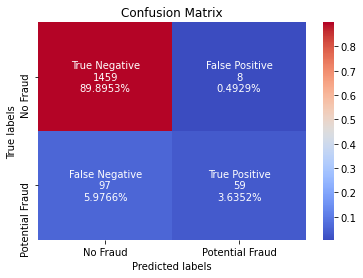

In [195]:
#SVM
svm= svm.SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

In [171]:
print("SVM model correctly classified %f percent of fraud cases in the test data" %((59/97)*100))
print("SVM model misclassified %f percent of non-fraud cases in the test data" %((8/1459)*100))

SVM model correctly classified 60.824742 percent of fraud cases in the test data
SVM model misclassified 0.548321 percent of non-fraud cases in the test data


Random Forest Accuracy Score: 0.9346888478126926
F1 Score: 0.5826771653543307
Confusion Matrix: 
[[1443   24]
 [  82   74]]


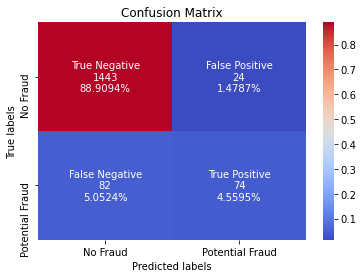

In [196]:
#Random Forest
rF = ensemble.RandomForestClassifier()
rF.fit(X_train, y_train)
y_pred = rF.predict(X_test)
print(f'Random Forest Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

In [174]:
print("Random Forest model correctly classified %f percent of fraud cases in the test data" %((70/86)*100))
print("Random Forest model misclassified %f percent of non-fraud cases in the test data" %((23/1444)*100))

Random Forest model correctly classified 81.395349 percent of fraud cases in the test data
Random Forest model misclassified 1.592798 percent of non-fraud cases in the test data


[12:42:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy Score: 0.9303758471965496
F1 Score: 0.5637065637065637


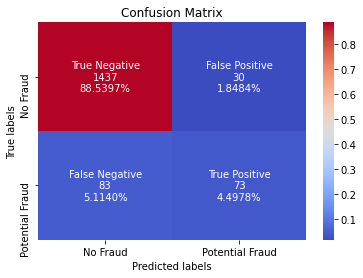

In [198]:
#XGB
xgb= XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f'XGBoost Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

In [178]:
print("XGBoost model correctly classified %f percent of fraud cases in the test data" %((73/83)*100))
print("XGBoost model misclassified %f percent of non-fraud cases in the test data" %((30/1437)*100))

XGBoost model correctly classified 87.951807 percent of fraud cases in the test data
XGBoost model misclassified 2.087683 percent of non-fraud cases in the test data
